# Описание проекта

Из банка стали уходить клиенты. Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

Столбец *Exited* отражает факт ухода клиента.

### Метрики

* *F1*-score > 0,59;
* *ROC-AUC*.

# Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
# Misc libs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

# Scikit-learn libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score,\
                            roc_curve,\
                            accuracy_score,\
                            confusion_matrix,\
                            recall_score,\
                            precision_score,\
                            f1_score

Сделаем некоторые общие настройки среды.

In [2]:
sns.set()
warnings.filterwarnings("ignore")

r_state = 123  # Здесь же зафиксируем значение random_state - сквозное по всему проекту

## Ознакомление с данными

Откроем файл и просмотрим данные.

In [3]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Файл открылся нормально, данные распознались корректно. Имеются пропуски в одном столбце - *Tenure*.

Столбцы *RowNumber*, *CustomerId* и *Surname* не нужны: достаточно индекса таблицы.

Удалим *RowNumber*, *CustomerId* и *Surname*, но перед этим сразу выполним проверку на наличие дубликатов.

In [5]:
df.duplicated().sum()

0

In [6]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Переименуем столбцы.

In [7]:
df.columns = df.columns.str.lower()

df.rename(columns={'creditscore': 'score',
                   'geography': 'country',
                   'numofproducts': 'products',
                   'hascrcard': 'card',
                   'isactivemember': 'active',
                   'estimatedsalary': 'salary'},
          inplace=True)

df.head()

,score,country,gender,age,tenure,balance,products,card,active,salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Теперь данные готовы к предобработке.

## Предобработка данных

### Рассмотрим столбец *score*

In [8]:
df.score.describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: score, dtype: float64

### Рассмотрим столбец *country*

In [9]:
df.country.value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

### Рассмотрим столбец *gender*

In [10]:
df.gender.value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

### Рассмотрим столбец *age*

In [11]:
df.age.describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

### Рассмотрим столбец *balance*

In [12]:
df.balance.describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64

Значения столбцов *score*, *country*, *gender*, *age*, *balance* - корректные, аномалий нет.

### Рассмотрим столбец *salary*

In [13]:
describe = df.salary.describe()
describe

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: salary, dtype: float64

Минимум аномально мал. Рассмотрим подробнее.

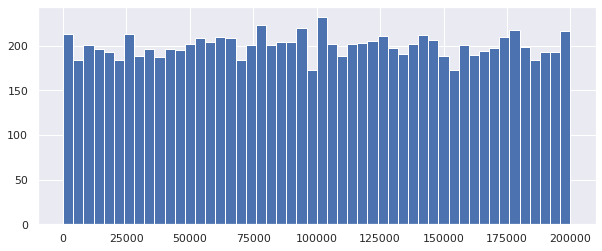

In [14]:
plt.figure(figsize=(10, 4))
plt.hist(df.salary, bins=50)
plt.show()

In [15]:
# The function builds a plot of the salary by index

def salary_plot(limit):
    plt.figure(figsize=(8, 3))
    df_plot = df.salary[df.salary < limit].sort_values()
    df_plot.reset_index(drop=True, inplace=True)
    plt.plot(df_plot)
    plt.show()

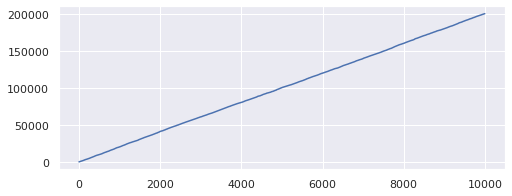

In [16]:
salary_plot(describe['max'])

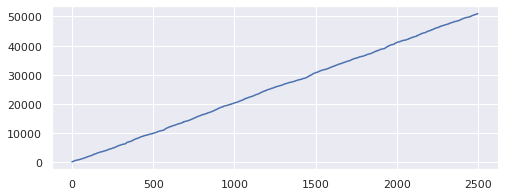

In [17]:
salary_plot(describe['25%'])

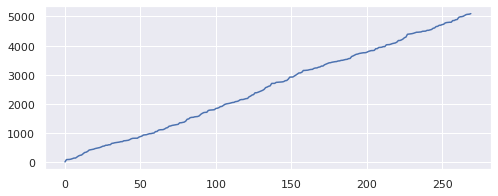

In [18]:
salary_plot(describe['25%'] / 10)

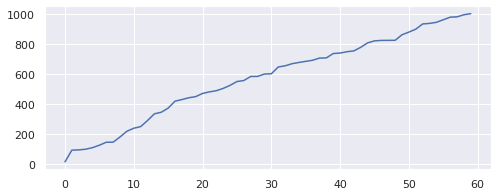

In [19]:
salary_plot(describe['25%'] / 50)

На гистограмме видно, что значения столбца *salary* распределены не нормально, а равномерно: клиентов с любым уровнем зарплаты у банка примерно поровну. Несмотря на то, что это лишь оценочные данные, несколько странно, что нет нижней границы: такая тенденция сохраняется вплоть до околонулевого минимума. Нет даже какой-либо "ступени".

В связи с этим не вполне понятно, что считать аномалией. Не понятно даже, годовая это зарплата или месячная. Не указана размерность. Поскольку речь идёт о странах, входящих в зону евро, скорее всего, зарплата указана в евро.

Отбросим совсем уж неправдоподобные значения. На последнем графике виден излом на уровне около 400 евро.

Удалим строки со значением *salary* менее 400.

In [20]:
df.query('salary < 400').count().max()

16

In [21]:
df.drop(df.query('salary < 400').index, inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9984 entries, 0 to 9983
Data columns (total 11 columns):
score       9984 non-null int64
country     9984 non-null object
gender      9984 non-null object
age         9984 non-null int64
tenure      9076 non-null float64
balance     9984 non-null float64
products    9984 non-null int64
card        9984 non-null int64
active      9984 non-null int64
salary      9984 non-null float64
exited      9984 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 858.1+ KB


In [22]:
df.salary.min()

417.41

### Рассмотрим столбцы *products*, *card*, *active*, *exited*

In [23]:
df.products.value_counts()

1    5077
2    4581
3     266
4      60
Name: products, dtype: int64

In [24]:
df.card.value_counts()

1    7041
0    2943
Name: card, dtype: int64

In [25]:
df.active.value_counts()

1    5141
0    4843
Name: active, dtype: int64

In [26]:
df.exited.value_counts()

0    7951
1    2033
Name: exited, dtype: int64

Всё в порядке, аномалий нет.

### Рассмотрим столбец *tenure*

*tenure* - единственный столбец, в котором есть пропуски.

In [27]:
df.tenure.value_counts().sort_index()

0.0     381
1.0     951
2.0     949
3.0     927
4.0     884
5.0     926
6.0     881
7.0     923
8.0     929
9.0     881
10.0    444
Name: tenure, dtype: int64

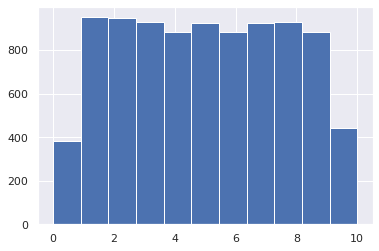

In [28]:
plt.hist(df.tenure, bins=11)
plt.ylim=(0, 10)
plt.show()

Согласно описанию данных, в столбце *tenure* содержится информация о количестве недвижимости у клиентов. Однако, данные заставляют в этом усомниться. Если бы это была некая количественная мера недвижимости, то мы бы увидели распределение Пуассона. Или что-то вида y=1/x. Здесь же - равномерное распределение.

Посовещавшись с коллегами, с учётом данных, а также принимая во внимание значение слова "tenure", принято решение считать этот столбец **сроком, на который выдаётся кредит**. При этом для решения задачи не столь важно, какова размерность - годы или месяцы. Допустим, **годы**.

Необходимо решить вопрос с пропусками. Есть три варианта действий:
* удалить строки с пропусками;
* удалить весь столбец;
* заполнить пропуски.

Заполнять пропуски некими искусственными значениями (например, медианой или случайными числами от 1 до 10), - возможно, не самая лучшая идея, так как мы не знаем, насколько в итоге критичен этот признак: можно существенно исказить результат, несмотря на возросшие метрики. Модель обучится **хорошо, но не тому**, чему нужно. Этот риск мы никак не уберём, так как **в тестовой выборке** будут также присутствовать объекты с **заполненными** пропусками, и проблема может не проявиться.

Удаление части объектов, т.е. уменьшение выборки, негативно отразится на обучении. Но 9% - это всё же **не фатально**. Можно попробовать.

Удаление столбца - тоже неплохой вариант. Мы не уменьшаем выборку, а был ли важен этот столбец, покажут метрики уже по факту. В отличие от заполнения пропусков, здесь мы **не рискуем** обучить модель **неправильно**. Модель либо обучится, либо нет, и мы это сразу увидим.

Сформируем два датасета:
* *data[0]* - удалены строки с пропусками;
* *data[1]* - удалён столбец *tenure*.

Будем рассматривать их **оба** до тех пор, пока это будет целесообразно.

In [29]:
data = []
data.append(df.dropna())
data.append(df.dropna(axis=1))

data[0].reset_index(drop=True, inplace=True)
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9076 entries, 0 to 9075
Data columns (total 11 columns):
score       9076 non-null int64
country     9076 non-null object
gender      9076 non-null object
age         9076 non-null int64
tenure      9076 non-null float64
balance     9076 non-null float64
products    9076 non-null int64
card        9076 non-null int64
active      9076 non-null int64
salary      9076 non-null float64
exited      9076 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 780.1+ KB


In [30]:
data[1].head()

,score,country,gender,age,balance,products,card,active,salary,exited
0,619,France,Female,42,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,125510.82,1,1,1,79084.10,0


Таблицы с признаками готовы. Теперь их необходимо преобразовать для машинного обучения.

## Преобразование признаков, разделение на выборки

Создадим списки с именами категориальных и количественных признаков.

In [31]:
numerical = []
numerical.append(['score', 'age', 'tenure', 'balance', 'products', 'salary'])
numerical.append(['score', 'age', 'balance', 'products', 'salary'])

В каждом категориальном признаке - 2-3 категории. Это позволяет применить технику прямого кодирования One-Hot Encoding (OHE). Размерность таблицы остаётся в разумных пределах. Удалим первые столбцы дамми-переменных во избежание попадания в дамми-ловушку (избыток взаимозависимых признаков).

Количественные признаки имеют разный порядок и разный разброс значений. Для корректного обучения необходимо привести такие признаки к одному масштабу. Благодаря масштабированию все признаки будут иметь во время обучения одинаковый вес.

Преобразование признаков проведём следующим образом:
* выполним прямое кодирование категориальных признаков;
* разделим данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1;
* выполним масштабирование количественных признаков в каждой выборке.

In [32]:
# The function transforms categorial and numerical data fitting it for ML purpose
# and returns splitted samples: train, valid, test and train+valid for the final training.

def data_transform(df, numerical):
    df_ohe = pd.get_dummies(df, drop_first=True)
    
    target = df_ohe.exited
    features = df_ohe.drop('exited', axis=1)

    scaler = StandardScaler()
    
    features_train_valid, features_test, target_train_valid, target_test = train_test_split(
        features, target, test_size=0.2, random_state=r_state)
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features_train_valid, target_train_valid, test_size=0.25, random_state=r_state)
    
    scaler.fit(features_train[numerical])
    
    features_train[numerical] = scaler.transform(features_train[numerical])
    features_valid[numerical] = scaler.transform(features_valid[numerical])
    
    features_train_valid[numerical] = scaler.transform(features_train_valid[numerical])
    features_test[numerical] = scaler.transform(features_test[numerical])
    
    return features_train_valid, target_train_valid, features_test, target_test, \
            features_train, target_train, features_valid, target_valid

Чтобы не усложнять код и систему переменных, будем применять функцию *data_transform* не в цикле, а "вручную", последовательно для каждого из двух случаев.

Проверим, корректно ли работает функция.

In [33]:
features_train_valid, target_train_valid, features_test, target_test, \
            features_train, target_train, features_valid, target_valid = data_transform(data[0], numerical[0])

features_valid.head()

,score,age,tenure,balance,products,card,active,salary,country_Germany,country_Spain,gender_Male
5492,0.719621,-0.658027,1.032589,-1.230975,0.799311,1,1,-1.040627,0,1,1
5445,-1.282892,-0.564003,-0.008412,-1.230975,0.799311,1,0,1.041367,0,1,1
4843,-1.054626,0.188185,-0.702413,1.198072,-0.923670,1,0,1.290184,1,0,1
8024,1.383667,0.282209,0.685588,0.800229,-0.923670,1,0,-1.067944,1,0,1
4985,0.190460,-0.658027,-1.743414,0.437430,-0.923670,1,0,-1.403377,1,0,1


In [34]:
print(features_train_valid.shape, target_train_valid.shape, features_test.shape, target_test.shape, \
            features_train.shape, target_train.shape, features_valid.shape, target_valid.shape)

(7260, 11) (7260,) (1816, 11) (1816,) (5445, 11) (5445,) (1815, 11) (1815,)


Результаты соответствуют ожидаемым.

## Вывод по подготовке данных

Файл с данными открылся нормально, данные - в хорошем состоянии. Пропуски (9,1% строк) имеет только один столбец (*tenure*). Удалены ненужные столбцы. Некоторые столбцы переименованы.

На этапе предобработки просмотрены данные всех столбцов. Удалено 16 строк (0,2%), в которых значения *salary* - аномально малые. Пропуски столбца *tenure* обработаны двумя способами: удаление строк с пропусками и удаление столбца целиком. Оба датасета сохранены, и лучший из них будет выявлен позднее.

Выполнено преобразование признаков и разделение данных на выборки: тренировочную, валидационную и тестовую в соотношении 3:1:1. Также сохранена выборка "тренировочная + валидационная" для обучения модели перед финальным тестированием. Признаки преобразованы следующим образом: категориальные (*country*, *gender*) - методом One-Hot Encoding (OHE); количественные - методом масштабирования.

Данные готовы к дальнейшей работе.

# Исследование задачи

## Словари, списки, функции

In [35]:
fit_predict_metrics_columns = ['f1', 'recall', 'precision', 'accuracy', 'accuracy_const']

In [36]:
# The function prints the ratio of pos and neg classes.

def class_ratio(target, output=True):
    ratio = target[target == 1].count() / target[target == 0].count()
    
    if output == True:
        print(round((ratio), 3))
    else:
        return ratio

In [37]:
# The function fits the passed model, forms an array of the predicted values,
# computes the metrics and return an array of them.

def fit_predict_metrics(model, features_train, target_train, features_valid, target_valid):
    # Forming a list of the predicted values
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    predicted_valid_constant = pd.Series(0, index=range(len(predicted_valid)))
    
    # Computing metrics
    array = []
    
    array.append(f1_score(target_valid, predicted_valid))
    array.append(recall_score(target_valid, predicted_valid))
    array.append(precision_score(target_valid, predicted_valid))
    array.append(accuracy_score(target_valid, predicted_valid))
    array.append(accuracy_score(target_valid, predicted_valid_constant))

    return array

In [38]:
# The function computes the metrics with 'fit_predict_metrics' function for different algorithms
# and for different values of hyperparameters. Then it forms the tables of the results.

def models_computing_func(features_train, target_train, features_valid, target_valid,
                          class_weight=None,
                          full_output=False):
    
    '''
    full_output=False - the function outputs only the highest F1-metrics and related essential information
    full_output=True  - the function outputs full tables of the metrics computed
    '''
    
    # Dicts of the loop parameters
    max_depth_params = {
        'min': 4,
        'max': 32,
        'step': 4
    }
    
    n_estimators_params = {
        'min': 10,
        'max': 100,
        'step': 10
    }
    
    # DecisionTreeClassifier
    metrics_row = []
    hyperparams = []

    for depth in range(max_depth_params['min'], max_depth_params['max']+1, max_depth_params['step']):
        metrics_row.append(fit_predict_metrics(DecisionTreeClassifier(max_depth=depth, 
                                                                      random_state=r_state,
                                                                      class_weight=class_weight),
                                               features_train, target_train, features_valid, target_valid)
                          )
        hyperparams.append(depth)

    metrics_table_DT = pd.DataFrame(data=metrics_row,
                                    index=hyperparams,
                                    columns=fit_predict_metrics_columns)
    metrics_table_DT.rename_axis('max_depth', axis=0, inplace=True)
    metrics_table_DT.reset_index(inplace=True)

    # RandomForestClassifier
    metrics_row = []
    hyperparams = []

    for estimators in range(n_estimators_params['min'], n_estimators_params['max']+1, n_estimators_params['step']):
        for depth in range(max_depth_params['min'], max_depth_params['max']+1, max_depth_params['step']):
            metrics_row.append(fit_predict_metrics(RandomForestClassifier(n_estimators=estimators,
                                                                          max_depth=depth,
                                                                          random_state=r_state,
                                                                          class_weight=class_weight),
                                                   features_train, target_train, features_valid, target_valid)
                              )
            hyperparams.append((estimators, depth))

    metrics_table_RF = pd.DataFrame(data=metrics_row,
                                    index=pd.MultiIndex.from_tuples(hyperparams, names=('n_estimators', 'max_depth')),
                                    columns=fit_predict_metrics_columns)
    metrics_table_RF.reset_index(inplace=True)

    # LogisticRegression
    metrics_row = []

    metrics_row.append(fit_predict_metrics(LogisticRegression(random_state=r_state,
                                                              class_weight=class_weight),
                                           features_train, target_train, features_valid, target_valid)
                      )

    metrics_table_LR = pd.DataFrame(data=metrics_row,
                                    columns=fit_predict_metrics_columns)
    
    # Table of the best results
    metrics_table_best = pd.DataFrame(data=[metrics_table_DT.loc[metrics_table_DT.f1.idxmax],
                                            metrics_table_RF.loc[metrics_table_RF.f1.idxmax],
                                            metrics_table_LR.loc[metrics_table_LR.f1.idxmax]],
                                      index=['Decision Tree', 'Random Forest', 'Logistic Regression'],
                                      columns=metrics_table_RF.loc[metrics_table_RF.f1.idxmax].index)
    metrics_table_best.fillna('-', inplace=True)

    # Output
    print('\nThe highest values of F1-metric and related essential information')
    display(metrics_table_best)
    
    if full_output == True:
        with pd.option_context('display.max_rows', 150):
            print('\n\n\nDecisionTreeClassifier')
            display(metrics_table_DT)
            print('\n\n\nRandomForestClassifier')
            display(metrics_table_RF)
            print('\n\n\nLogisticRegression')
            display(metrics_table_LR)
            print()

## Исследование баланса классов

Под балансом классов понимается соотношение положительных и отрицательных классов целевого признака. В нашем случае - "0" и "1" столбца *exited*. Если соотношение близко к 1:1, то классы считаются сбалансированными. В противном случае - нет.

Вычислим соотношение классов.

In [39]:
class_ratio(df.exited)
class_ratio(target_train_valid)
class_ratio(target_train)
class_ratio(target_valid)
class_ratio(target_test)

0.256
0.256
0.264
0.233
0.256


Во всех выборках отношение положительного класса к отрицательному - примерно 1:3. Или, по-другому, положительный класс составляет примерно 25% от размера выборки.

Выборки с таким соотношением классов считаются **несбалансированными**.

## Исследование моделей без учёта дисбаланса

Качество модели измеряется подходящими метриками.

Для моделей-классификаторов в том случае, когда классы целевого признака не сбалансированы, хорошо подходят метрики *Recall* (полнота) и *Precision* (точность). Их необходимо использовать совместно, так как по отдельности они малоинформативны: при росте полноты может падать точность, и - наоборот.

Существует также *F1*-мера - среднее гармоническое полноты и точности. *F1*-мера как раз комбинирует эти метрики так, что высокое значение получается, если полнота и точность высокие одновременно. А вот снижается *F1*-мера при снижении хотя бы одной из метрик (если речь идёт о низких значениях).

*Accuracy* (тоже точность, но другая: считает долю верно предсказанных классов) для несбалансированных классов не очень годится, так как частый класс угадать случайно более вероятно, чем редкий класс, и даже константная модель будет показывать высокое, на первый взгляд, значение метрики. Чем больше дисбаланс, тем труднее интерпретировать результат.

При помощи метрики *Accuracy* желательно проверять модель на адекватность: модель адекватна, если её *Accuracy* выше, чем у константной модели.

Рассчитаем указанные метрики для разных алгоритмов (*DecisionTreeClassifier*, *RandomForestClassifier*, *LogisticRegression*) с различными гиперпараметрами. Рассматривать будем, прежде всего, *F1*-меру.

### Исследование моделей на датасете с удалёнными строками (*data[0]*)

Сформируем выборки с помощью функции '*data_transform*'.

In [40]:
features_train_valid, target_train_valid, features_test, target_test, \
            features_train, target_train, features_valid, target_valid = data_transform(data[0], numerical[0])

Рассчитаем метрики с помощью функции '*models_computing_func*'.

In [41]:
models_computing_func(features_train, target_train, features_valid, target_valid)


The highest values of F1-metric and related essential information


,n_estimators,max_depth,f1,recall,precision,accuracy,accuracy_const
Decision Tree,-,8,0.519355,0.469388,0.581227,0.835813,0.811019
Random Forest,100,20,0.567857,0.463557,0.732719,0.866667,0.811019
Logistic Regression,-,-,0.279661,0.192420,0.511628,0.812672,0.811019


Из таблицы видно, что наиболее качественная модель по метрике *F1* - Случайный лес. Чуть меньшее значение метрики - у Решающего дерева. Обе модели получились качественнее константной.

А вот у Логистической регрессии *F1* примерно вдвое ниже, чем у деревьев, и такая модель оказалась не "умнее" константной. Отловила только каждый пятый положительный объект. И при этом имеется почти такое же количество ложноположительных ответов.

### Исследование моделей на датасете с удалённым столбцом (*data[1]*)

Проведём такие же расчёты на другом датасете.

Сформируем выборки с помощью функции '*data_transform*'.

In [42]:
features_train_valid, target_train_valid, features_test, target_test, \
            features_train, target_train, features_valid, target_valid = data_transform(data[1], numerical[1])

Рассчитаем метрики с помощью функции '*models_computing_func*'.

Функция предусматривает возможность просмотреть все рассчитанные метрики. Для этого необходимо передать в функцию параметр *full_output=True*. Важная информация расположена вверху и видна сразу, а для просмотра остальных результатов нужно скроллить ячейку вниз.

In [43]:
models_computing_func(features_train, target_train, features_valid, target_valid,
                      full_output=True)


The highest values of F1-metric and related essential information


,n_estimators,max_depth,f1,recall,precision,accuracy,accuracy_const
Decision Tree,-,8,0.570270,0.480638,0.700997,0.840761,0.78017
Random Forest,80,28,0.593923,0.489749,0.754386,0.852779,0.78017
Logistic Regression,-,-,0.312605,0.211845,0.596154,0.795193,0.78017





DecisionTreeClassifier


,max_depth,f1,recall,precision,accuracy,accuracy_const
0,4,0.483092,0.341686,0.824176,0.839259,0.78017
1,8,0.570270,0.480638,0.700997,0.840761,0.78017
2,12,0.547500,0.498861,0.606648,0.818728,0.78017
3,16,0.521945,0.501139,0.544554,0.798197,0.78017
4,20,0.530425,0.526196,0.534722,0.795193,0.78017
5,24,0.522034,0.526196,0.517937,0.788182,0.78017
6,28,0.522034,0.526196,0.517937,0.788182,0.78017
7,32,0.522034,0.526196,0.517937,0.788182,0.78017





RandomForestClassifier


,n_estimators,max_depth,f1,recall,precision,accuracy,accuracy_const
0,10,4,0.419411,0.275626,0.876812,0.832248,0.78017
1,10,8,0.536210,0.396355,0.828571,0.849274,0.78017
2,10,12,0.555091,0.453303,0.715827,0.840260,0.78017
3,10,16,0.565934,0.469248,0.712803,0.841763,0.78017
4,10,20,0.562942,0.453303,0.742537,0.845268,0.78017
5,10,24,0.558533,0.451025,0.733333,0.843265,0.78017
6,10,28,0.558533,0.451025,0.733333,0.843265,0.78017
7,10,32,0.558533,0.451025,0.733333,0.843265,0.78017
8,20,4,0.432526,0.284738,0.899281,0.835754,0.78017
9,20,8,0.558069,0.421412,0.825893,0.853280,0.78017





LogisticRegression


,f1,recall,precision,accuracy,accuracy_const
0,0.312605,0.211845,0.596154,0.795193,0.78017


Во время просмотра полной таблицы можно увидеть интересные вещи. Например, несколько раз попадается стопроцентная точность (*Precision* = 1,0) при крайне низкой полноте (*Recall* < 0,1).

На этом датасете модели показали более высокие результаты: значения метрики *F1* повысились примерно на 0,03...0,05.

У Логистической регрессии появилось небольшое, но заметное отличие от константной модели, и теперь её тоже можно считать адекватной.

### Выбор лучшего датасета

Получен ответ на вопрос, какой датасет - лучше: с удалёнными строками или с удалённым столбцом. Оказалось, что **более высокое качество** (по метрике *F1*) показывают модели, обученные на датасете **с удалённым столбцом**.

Сохранение размера обучающей выборки (отказ от её уменьшения) оказалось важнее для обучения моделей, чем сохранение одного из признаков. Потеря одного признака не столь критична, как потеря 9% объектов.

Из трёх рассмотренных алгоритмов наилучшие результаты (по метрике *F1*) показал *RandomForestClassifier* (на обоих датасетах).

В **дальнейшем исследовании** будет использоваться только один датасет - тот, в котором **удалён столбец *tenure*** (*data[1]*).

In [44]:
data = data[1]
numerical = numerical[1]

data.shape

(9984, 10)

In [45]:
data.head()

,score,country,gender,age,balance,products,card,active,salary,exited
0,619,France,Female,42,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,125510.82,1,1,1,79084.10,0


In [46]:
numerical

['score', 'age', 'balance', 'products', 'salary']

## Вывод по исследованию задачи

Исследован баланс классов. Целевой признак не сбалансирован: положительный класс составляет примерно 25% от размера выборки.

Исследовались алгоритмы *DecisionTreeClassifier*, *RandomForestClassifier*, *LogisticRegression*. Выполнено обучение моделей с различными значениями гиперпараметров без учёта дисбаланса классов целевого признака. Для каждой модели получены метрики *F1*, *Recall*, *Precision*, *Accuracy*. Выполнена проверка на адекватность путём сравнения *Accuracy* с таковой для константной модели (массив, заполненный только нулями).

Одно и то же исследование проведено на двух датасетах:
* *data[0]* - удалены строки с пропусками;
* *data[1]* - удалён столбец *tenure*.

На обоих датасетах модели показали в целом схожие результаты, но *data[1]* оказался лучше. Оказалось **предпочтительнее** сохранить (**не уменьшать**) исходный размер выборки, нежели сохранять все признаки (столбцы).

Наибольшее значение метрики *F1* показал алгоритм *RandomForestClassifier*: *F1* = 0,59 при *n_estimators* = 35 и *max_depth* = 20. Чуть меньше - у *DecisionTreeClassifier* (*F1* = 0,57 при *max_depth* = 8). У *LogisticRegression* - меньше почти вдвое (*F1* = 0,31).

Другие метрики лучшей модели: *Recall* = 0,49; *Precision* = 0,76. Модель покрыла почти половину положительных объектов. А из тех объектов, которые модель признала положительными, примерно четверть на самом деле таковыми не являются. *Accuracy* = 0,85; *Accuracy* константной модели = 0,78. Количество верно предсказанных объектов на 7 процентных пунктов больше по сравнению с константной моделью: полученная модель адекватна.

# Борьба с дисбалансом

Для того, чтобы улучшить качество модели, необходимо устранить дисбаланс классов целевого признака. Сделать это можно несколькими способами:
* взвешиванием классов (аргумент *class_weight*);
* изменением размера выборки (upsampling; downsampling).

На изменённых этими тремя способами выборках построим различные модели. Возьмём те же алгоритмы, что и на предыдущем этапе (*DecisionTreeClassifier*, *RandomForestClassifier*, *LogisticRegression*), и сравним модели с различными значениями гиперпараметров.

## Функции

In [47]:
# The function increases the amount of the objects of the positive class or decreases the same of the negative one.

def sampling(features, target, method):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    coef = class_ratio(target, output=False)
    
    if method == 'up':
        coef = int(round((1 / coef), 0))
        features_sampled = pd.concat([features_zeros] + [features_ones] * coef)
        target_sampled = pd.concat([target_zeros] + [target_ones] * coef)
    elif method == 'down':
        features_sampled = pd.concat([features_zeros.sample(frac=coef, random_state=r_state)] + [features_ones])
        target_sampled = pd.concat([target_zeros.sample(frac=coef, random_state=r_state)] + [target_ones])
    else:
        features_sampled = features
        target_sampled = target
    
    features_sampled, target_sampled = shuffle(features_sampled, target_sampled, random_state=r_state)
    
    print('total amount original: {}\nmultiply coefficient: {:.3f}\namount of pos objects: {}\
          \namount of neg objects: {}\ntotal amount {}sampled: {}'
          .format(target.count(),
                  coef,
                  target_sampled[target_sampled == 1].count(),
                  target_sampled[target_sampled == 0].count(),
                  method,
                  target_sampled.count()
                 )
         )
    
    return features_sampled, target_sampled

## Изменение весов классов с помощью аргумента *class_weight*

Аргумент *class_weight*='balanced' увеличивает вес редкого класса во столько раз, во сколько раз меньше последний представлен в выборке по сравнению с частым классом. Вес редкого класса становится больше единицы, а вес частого - остаётся равен единице.

Готовый датасет уже имеется.

Сформируем выборки и рассчитаем метрики, как уже делали это выше.

In [48]:
features_train_valid, target_train_valid, features_test, target_test, \
            features_train, target_train, features_valid, target_valid = data_transform(data, numerical)

In [49]:
models_computing_func(features_train, target_train, features_valid, target_valid,
                      class_weight='balanced')


The highest values of F1-metric and related essential information


,n_estimators,max_depth,f1,recall,precision,accuracy,accuracy_const
Decision Tree,-,8,0.566604,0.687927,0.481659,0.768653,0.78017
Random Forest,20,8,0.633833,0.674260,0.597980,0.828743,0.78017
Logistic Regression,-,-,0.506734,0.685649,0.401869,0.706560,0.78017


Значения метрики *F1* **улучшились** у моделей всех трёх алгоритмов, но **не всё так просто**.

Лучшие по метрике *F1* модели Решающего дерева и Логистической регрессии имеют качество ниже, чем константная модель, то есть они **не адекватны**! **Сохранил** свою адекватность лишь **Случайный лес**, хотя *Accuracy* здесь ниже, чем до балансировки (было 0,85).

По сравнению с несбалансированными классами, здесь у всех моделей значительно **увеличился охват**, но на столько же **уменьшилась точность**. Значения этих метрик как бы "поменялись местами".

Наиболее **качественная** (и вместе с тем единственно приемлемая) модель - **Случайный лес** (значения метрик и параметров указаны в таблице).

## Увеличение размера выборки (upsampling)

Увеличение размера выборки заключается в копировании объектов редкого класса, чтобы в результате их стало примерно столько же, сколько объектов частого класса:
* разделим обучающую выборку на положительные и отрицательные объекты;
* скопируем положительные объекты несколько раз, добиваясь паритета с отрицательными;
* объединим выборки и перемешаем объекты.

Создадим соответствующую функцию (её код, как обычно, вынесен в начало данного раздела) и с её помощью выполним преобразование обучающей выборки.

In [50]:
features_train_upsampled, target_train_upsampled = sampling(features_train, target_train, method='up')

total amount original: 5990
multiply coefficient: 4.000
amount of pos objects: 4824          
amount of neg objects: 4784
total amount upsampled: 9608


Общее количество объектов в обучающей выборке стало больше, но - за счёт повторяющихся объектов.

Обучим модели и рассчитаем метрики.

In [51]:
models_computing_func(features_train_upsampled, target_train_upsampled, features_valid, target_valid)


The highest values of F1-metric and related essential information


,n_estimators,max_depth,f1,recall,precision,accuracy,accuracy_const
Decision Tree,-,8,0.569288,0.692483,0.483307,0.769654,0.78017
Random Forest,80,12,0.633371,0.635535,0.631222,0.838257,0.78017
Logistic Regression,-,-,0.505863,0.687927,0.400000,0.704557,0.78017


Метрики *F1* и *Accuracy* практически **не изменились** по сравнению с таковыми при **изменении весов** классов. У Случайного леса изменился баланс между *Recall* и *Precision*.

И так же, как и предыдущем случае, получилось с адекватностью моделей: **адекватен** только **Случайный лес**. Остальные - нет.

## Уменьшение размера выборки (downsampling)

Уменьшение размера выборки заключается в удалении из выборки случайно выбранных объектов частого класса так, чтобы количество оставшихся объектов частого класса приблизительно соответствовало количеству объектов редкого класса.

Это можно сделать с помощью метода *sample* объекта *DataFrame* (pandas). Уменьшение размера выборки выполняется той же функцией, что и увеличение - *sampling*.

In [52]:
features_train_downsampled, target_train_downsampled = sampling(features_train, target_train, method='down')

total amount original: 5990
multiply coefficient: 0.252
amount of pos objects: 1206          
amount of neg objects: 1206
total amount downsampled: 2412


Общее количество объектов в обучающей выборке стало меньше. Можно даже сказать, что их стало слишком мало - модели могут потерять в качестве из-за недообучения.

Обучим модели и рассчитаем метрики.

In [53]:
models_computing_func(features_train_downsampled, target_train_downsampled, features_valid, target_valid)


The highest values of F1-metric and related essential information


,n_estimators,max_depth,f1,recall,precision,accuracy,accuracy_const
Decision Tree,-,4,0.569330,0.706150,0.476923,0.765148,0.78017
Random Forest,40,12,0.604207,0.719818,0.520593,0.792689,0.78017
Logistic Regression,-,-,0.505068,0.681093,0.401342,0.706560,0.78017


Да, результаты ухудшились - значения метрик **снизились**, особенно у Случайного леса. Можно лишь добавить, что модель, обученная по алгоритму *Random Forest*, пока ещё качественнее константной модели, а также показывает на валидационной выборке удовлетворительный результат с точки зрения ТЗ.

## Изменение порога

### Построение ROC-кривой

ROC-кривая удобна для исследования метрик *TPR* и *FPR* - долей истинноположительных и ложноположительных ответов соответственно. Эти две метрики взаимосвязаны: у случайной модели они будут стремиться к значениям друг друга, а у идеального классификатора - *TPR*=1 и *FPR*=0.

Значения этих метрик изменяются в зависимости от порога (при вероятности выше порога модель относит объект к положительному классу; ниже - к отрицательному). Наиболее качественной модели соответствует точка на ROC-кривой, ближайшая к левому верхнему углу (0; 1). ROC-кривая случайной модели - прямой отрезок из левого нижнего угла (0; 0) в правый верхний (1; 1).

Построим ROC-кривую для наиболее качественной модели: *Random Forest*, обученный на увеличенной выборке (upsampling), с гиперпараметрами из таблицы лучших результатов.

Создадим модель, обучим её на тренировочной upsampling-выборке, рассчитаем вероятности классов и выделим в отдельный массив вероятности положительного класса.

In [54]:
model_best = RandomForestClassifier(n_estimators=80,
                                    max_depth=12,
                                    random_state=r_state,
                                    class_weight=None)

model_best.fit(features_train_upsampled, target_train_upsampled)

probabilities_valid = model_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Построим ROC-кривую.

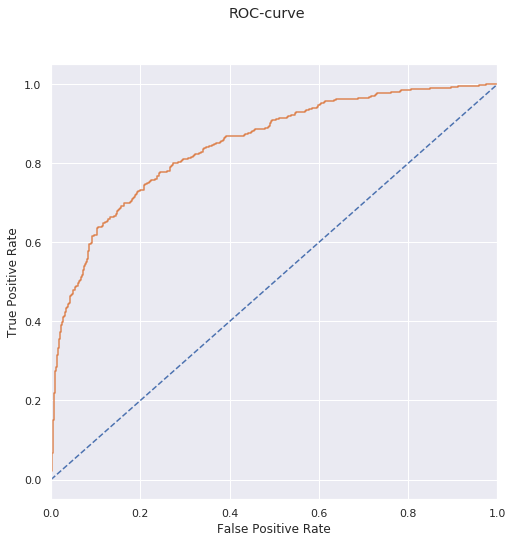

In [55]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(8, 8))
plt.suptitle('ROC-curve')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

plt.xlim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

ROC-кривая выглядит ожидаемо: возрастает монотонно, без резких всплесков и каких-либо аномалий. ROC-кривая находится выше ROC-кривой случайной модели (пунктирная прямая). Это хорошо: чем выше кривая над прямой, тем качественнее модель.

### Исследование метрики ROC-AUC

Порог можно рассматривать как ещё один гиперпараметр: изменять его и тем самым влиять на метрики.

Рассчитаем метрики качества для разных порогов. Найдём пороги, дающие самые высокие метрики *F1* и *ROC-AUC* (площадь под ROC-кривой - чем больше, тем лучше).

In [56]:
metrics_threshold = []

threshold_range = {
    'min': 0.0,
    'max': 1.01,
    'step': 0.02
}

for threshold in np.arange(threshold_range['min'], threshold_range['max'], threshold_range['step']):
    predicted_valid = probabilities_one_valid > threshold
    predicted_valid_constant = pd.Series(0, index=range(len(predicted_valid)))

    array = []
    
    array.append(f1_score(target_valid, predicted_valid))
    array.append(recall_score(target_valid, predicted_valid))
    array.append(precision_score(target_valid, predicted_valid))
    array.append(roc_auc_score(target_valid, predicted_valid))
    array.append(accuracy_score(target_valid, predicted_valid))
    array.append(accuracy_score(target_valid, predicted_valid_constant))
    
    metrics_threshold.append(array)

metrics_threshold_list = ['f1', 'recall', 'precision', 'roc_auc', 'accuracy', 'accuracy_const']
metrics_threshold_table = pd.DataFrame(data=metrics_threshold,
                                       index=np.arange(threshold_range['min'],
                                                       threshold_range['max'],
                                                       threshold_range['step']),
                                       columns=metrics_threshold_list)

metrics_threshold_table.rename_axis('threshold', axis=0, inplace=True)
metrics_threshold_table.reset_index(inplace=True)

metrics_threshold_table_best = pd.DataFrame(data=[metrics_threshold_table.loc[metrics_threshold_table.f1.idxmax],
                                                  metrics_threshold_table.loc[metrics_threshold_table.roc_auc.idxmax]],
                                            index=['the highest f1', 'the highest roc_auc'],
                                            columns=metrics_threshold_table.columns
                                           )
display(metrics_threshold_table_best)

,threshold,f1,recall,precision,roc_auc,accuracy,accuracy_const
the highest f1,0.5,0.633371,0.635535,0.631222,0.765457,0.838257,0.78017
the highest roc_auc,0.4,0.612613,0.697039,0.546429,0.767005,0.806209,0.78017


Значение метрики *ROC-AUC* при пороге 0,4 получилось немного более высоким, чем при пороге 0,5 (порог по умолчанию). Однако, **остальные метрики** - наоборот - при пороге 0,4 получаются **заметно хуже**.

Таким образом, **наиболее качественная** модель (с самыми высокими метриками *F1* и *AUC-ROC*) получается при пороге, равном 0,5 (**порог по умолчанию**).

## Вывод по борьбе с дисбалансом

Рассмотрены следующие способы устранения дисбаланса:
* изменение весов классов с помощью аргумента *class_weight*;
* увеличение размера выборки (upsampling);
* уменьшение размера выборки (downsampling).

Также был исследован порог, по которому модель принимает решение об отнесении объекта к тому или иному классу. Его изменение не устраняет дисбаланс напрямую, но влечёт эффект, похожий на взвешивание классов.

В первых трёх случаях **адекватными** получились только модели по алгоритму ***Random Forest***. У моделей по алгоритмам Decision Tree и Logistic Regression значение метрики *Accuracy* заметно **ниже**, чем таковое у константной модели. 

Наиболее высокий результат по метрикам принесло **увеличение размера выборки (upsampling)**: все рассматриваемые метрики получились достаточно высокими (*F1*=0.633; *Recall*=0.636; *Precision*=0.631; *Accuracy*=0.838). При этом большие значения гиперпараметров (количество деревьев - 80, глубина дерева - 12) повышают уверенность в том, что этот результат - не случаен и, вероятно, будет воспроизведён на тестовой выборке.

Для лучшей модели была исследована возможность повысить качество в ещё большей степени путём изменения порога. При этом, помимо прочих, рассматривалась метрика *AUC-ROC* - площадь под ROC-кривой. Соответственно, была построена ROC-кривая. В итоге, **самое высокое** качество получилось при пороге, установленном в значение **по умолчанию** - 0.5. Метрика *AUC-ROC*=0.765. При пороге 0,4 значение метрики *AUC-ROC* незначительно повышается (до 0.767), но остальные метрики - заметно снижаются.

Таким образом, наиболее качественная модель:
* создана по алгоритму *Random Forest*;
* дисбаланс классов целевого признака устранён увеличением размера выборки (upsampling);
* гиперпараметры: n_estimators=80, max_depth=12 (остальные - по умолчанию);
* порог не изменён и равен 0,5 - по умолчанию.

Теперь следует протестировать модель на тестовой выборке.

# Тестирование модели

Подготовим выборку для обучения модели перед тестированием. Возьмём выборку *train_valid*, включающую в себя тренировочную и валидационную выборки, и увеличим её размер, устраняя дисбаланс (метод upsampling).

In [57]:
features_train_valid_upsampled, target_train_valid_upsampled = sampling(features_train_valid, target_train_valid, method='up')

total amount original: 7987
multiply coefficient: 4.000
amount of pos objects: 6580          
amount of neg objects: 6342
total amount upsampled: 12922


Обучим модель и рассчитаем метрики *F1* и *ROC-AUC*.

Согласно ТЗ, целевое значение метрики *F1* - не менее 0,59.

In [58]:
model_best.fit(features_train_valid_upsampled, target_train_valid_upsampled)
predicted_test = model_best.predict(features_test)
predicted_test_constant = pd.Series(0, index=range(len(predicted_test)))

print('\nFinal testing results\nF1 score:       {:.3f}\nROC-AUC score:  {:.3f}\nAccuracy score: {:.3f}\nAcc.cnst score: {:.3f}'
      .format(f1_score(target_test, predicted_test),
              roc_auc_score(target_test, predicted_test),
              accuracy_score(target_test, predicted_test),
              accuracy_score(target_test, predicted_test_constant)
             )
     )


Final testing results
F1 score:       0.594
ROC-AUC score:  0.758
Accuracy score: 0.830
Acc.cnst score: 0.806


## Вывод по тестированию модели

Выполнена проверка самой качественной модели на тестовой выборке. Значение метрики *F1* меньше на 0.04 по сравнению с метрикой, полученной на валидационной выборке, и составило ***F1*=0.594**. Полученный результат удовлетворяет требованиям ТЗ.

Модель - адекватна: значение *Accuracy* - выше, чем у константной модели.

Значение метрики *ROC-AUC* значительно выше, чем 0.5, что также говорит о преимуществе по сравнению со случайной моделью.

# Общий вывод

##### Подготовка данных #####

На этапе предобработки удалены строки с некорректными значениями столбца *salary* (16 строк). В столбце *tenure* принято решение не заполнять пропуски во избежание искажения результатов обучения, а удалить их двумя способами: 1) удалить строки с пропусками; 2) удалить столбец целиком. Лучший из двух полученных датасетов определяется на следующем этапе.

Выполнено разделение данных на выборки: тренировочную, валидационную и тестовую в соотношении 3:1:1. Выполнено преобразование признаков: категориальные - методом OHE, количественные - методом масштабирования.

##### Исследование задачи #####

Исследован баланс классов: положительный класс составляет 25% от размера выборки.

Исследовались алгоритмы *DecisionTreeClassifier*, *RandomForestClassifier*, *LogisticRegression* с различными значениями гиперпараметров без учёта дисбаланса классов целевого признака. Метрики *F1*, *Recall*, *Precision*, *Accuracy* сведены в таблицу. По метрике *F1* выбраны лучшие модели по каждому алгоритму. Выполнена проверка на адекватность по *Accuracy* константной модели.

Наиболее высокие результаты показал алгоритм *RandomForestClassifier* на датасете с удалённым полностью столбцом *tenure*.

##### Борьба с дисбалансом #####

Рассмотрены следующие способы устранения дисбаланса:
* изменение весов классов с помощью аргумента *class_weight*;
* увеличение размера выборки (upsampling);
* уменьшение размера выборки (downsampling);
* к лучшей модели было применено также изменение порога.

Лучшие и вместе с тем единственно адекватные модели были созданы по алгоритму Random Forest. Остальные - утратили адекватность (*Accuracy* ниже, чем у константной модели).

Самые высокие значения метрик (прежде всего, *F1*) достигнуты при увеличении размера выборки (upsampling). На валидационной выборке *F1*=0.633. Поскольку гиперпараметры в этом случае приняли довольно большие значения (n_estimators=80, max_depth=12), результат представляется твёрдым (неслучайным), и ожидается его успешное подтверждение на тестовой выборке.

Этот результат был достигнут при пороге по умолчанию (0.5); значение метрики *AUC-ROC*=0.765 - тоже самое высокое (если пренебречь небольшой погрешностью).

##### Тестирование модели #####

При проверке на тестовой выборке модель показала значение метрики *F1*, удовлетворяющее требованиям ТЗ: *F1*=0,594. Метрики *Accuracy* и *ROC-AUC* также говорят об адекватности модели и её высоком качестве.

##### Заключение #####

Модель успешно прошла проверку на соответствие требованиям ТЗ и не имеет иных нареканий.

Можно передавать модель заказчику для реального применения.